In [3]:
import pandas as pd
import numpy as np
import time
import gc

In [5]:
path = '../data/'
train_sample = pd.read_csv(path + 'train_sample_cleaned_final.csv')

In [9]:
train_sample.dtypes

ip               int64
app              int64
device           int64
os               int64
channel          int64
day              int64
hour             int64
timestamp        int64
minute           int64
second           int64
is_attributed    int64
dtype: object

In [136]:
from lightfm import LightFM
import scipy.sparse as sp
from scipy.sparse import coo_matrix
from lightfm import LightFM
from sklearn.preprocessing import LabelEncoder

orders = {}
feature_col = ['ip', 
              'app', 
              'device', 
              'os', 
              'channel',
              'day',
              'hour',
              'timestamp',
              'minute',
              'second']
    
for col in feature_col:
    orders[col] = 10 ** (int(np.log(train_sample[col].max() + 1) / np.log(10)) + 1)    

def get_group(df, cols):
    """
    define an encoding method which can ganrantee the combination will be unique.
    eg: artist_name_composer will be a combination of (artist_name,composer) 
        and the encoding will reflect the unqiue combination of those two
    """
    group = df[cols[0]].copy()
    for col in cols[1:]:
        group = group * orders[col] + df[col]
        
    return group

def matrix_factorization(df, df_history, target, item_col, userid_col, userraw_col):
    """
    userid_col is unique user id
    item_col is unique itme id
    userraw_col is used to construct user feature. dim: user_id*userraw
    """
    dff = pd.DataFrame()
    dff_history = pd.DataFrame()


    #1. process item
    if item_col is None:
        dff['item'] = np.zeros(len(df))
        dff_history['item'] = np.zeros(len(df_history))
    else:
        encoder = LabelEncoder()
        group = get_group(df, item_col)
        group_history = get_group(df_history, item_col)
        encoder.fit(pd.concat([group, group_history]))
        dff['item'] = encoder.transform(group)
        dff_history['item'] = encoder.transform(group_history)
#     print('processing item done!')

    #2. user raw
    group = get_group(df, userraw_col)
    group_history = get_group(df_history, userraw_col)
    encoder = LabelEncoder()
    encoder.fit(pd.concat([group, group_history]))
    dff['userraw'] = encoder.transform(group)
    dff_history['userraw'] = encoder.transform(group_history)
#     print('processing user raw done')


    #3. user_id
    group = get_group(df, userid_col)
    group_history = get_group(df_history, userid_col)
    encoder = LabelEncoder()
    encoder.fit(pd.concat([group, group_history]))
    dff['user_id'] = encoder.transform(group)
    dff_history['user_id'] = encoder.transform(group_history)
#     print('processing user id done')



    num_users = max(dff.user_id.max(), dff_history.user_id.max()) + 1
    num_items = max(dff.item.max(), dff_history.item.max()) + 1
    num_userraw = max(dff.userraw.max(), dff_history.userraw.max()) + 1

    M = coo_matrix(
            (df_history[target], ( dff_history.user_id, dff_history.item)),
            shape=(num_users, num_items)
        )

    user_features = pd.concat([dff, dff_history])[['userraw', 'user_id']].drop_duplicates()

    user_features = coo_matrix(
        (np.ones(len(user_features)), (user_features.user_id, user_features.userraw)),
        shape=(num_users, num_userraw)
    )

    user_features = sp.hstack([sp.eye(num_users), user_features])

    model = LightFM(no_components=50, learning_rate=0.1)

    model.fit(
            M, 
            epochs=2, 
            num_threads=50, 
            user_features=user_features,
        )
    result = model.predict(
        dff.user_id.values, 
        dff.item.values, 
        user_features=user_features,
    )
    return result

target = 'is_attributed'
# item_col = ['app','device','os']
# userid_col = ['ip','os','device','app','channel']
item_col = ['device','app']
userid_col = ['ip','device','app']
userraw_col = ['ip']
result = matrix_factorization(train_sample, train_sample,target, item_col, userid_col, userraw_col)

print('done')

done


In [137]:
view = pd.DataFrame()
view['preds'] = result
view['ori'] = train_sample.is_attributed.values

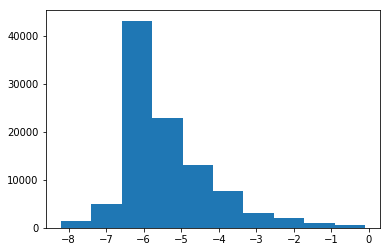

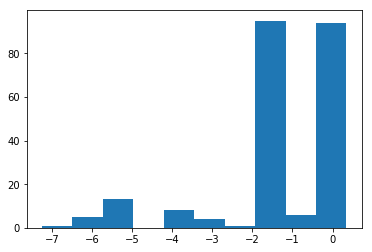

In [135]:
import matplotlib.pyplot as plt

x = view[view.ori==1]['preds'].values
y = view[view.ori==0]['preds'].values

plt.hist([y])
plt.show()

plt.hist([x])
plt.show()

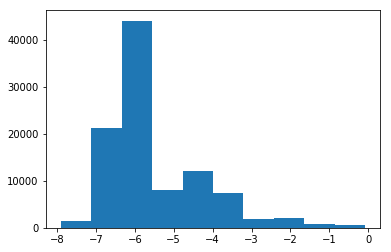

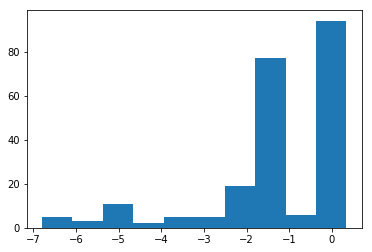

In [138]:
import matplotlib.pyplot as plt

x = view[view.ori==1]['preds'].values
y = view[view.ori==0]['preds'].values

plt.hist([y])
plt.show()

plt.hist([x])
plt.show()